## **Network Analysis: 2-Mode Networks**

**Submitted by:** Euclides

**Course:** CUNY DATA 620

**Data Source: Link:** https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FLM&QO_fu146_anzr=b4vtv0+n0q+Qr56v0n6v10+f748rB

### **Introduction**

**Project:**
1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

**Dataset:**  
  
Airline Origin and Destination Survey: Thie dataset contains information for each domestic itinerary of the Origin and Destination Survey, such as the operating carrier, origin and destination airports, number of passengers, fare class, coupon type, trip break indicator, and distance.  The primary concern of this study is to analyze the network of destinations cities for two major carriers. 

Year: Year

OriginCityMarketID: Origin Airport, City Market ID. City Market ID is an identification number assigned by US DOT to identify a city market. Use this field to consolidate airports serving the same city market.

DestCityMarketID: Destination Airport, City Market ID. City Market ID is an identification number assigned by US DOT to identify a city market. Use this field to consolidate airports serving the same city market.

OpCarrier: Operating Carrier Code



### **Load Data and Seperation for Positive and Negative Sentiment**

In [141]:

# Import packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import itertools
from networkx.algorithms import bipartite as bi
import numpy as np

In [153]:
#Load csv into a Dataframe
current_dir = os.getcwd()
filename = "Origin_and_Destination_Survey_DB1BCoupon_2023_3.csv"
file_path = os.path.join(current_dir, filename)

#import data and create subset with select columns only
df = pd.read_csv(file_path)
df = df[["OpCarrier","DestCityMarketID", "Distance"]]
df.head()

,OpCarrier,DestCityMarketID,Distance
0,DL,30397,270.0
1,DL,30397,270.0
2,DL,30397,270.0
3,DL,30397,270.0
4,DL,30397,270.0


In [ ]:
# Obtain counts of carrier 
counts = df['OpCarrier'].value_counts()

# Option most frequent carriers
top = counts.nlargest(10).index

# Create a subset dataframe with the top  carriers to reduce computing requirements 
df_sub1 = df[df['OpCarrier'].isin(top)]

In [ ]:
# Create a directed graph
g = nx.Graph()

# Extract unique destination cities and carriers
carriers = df_sub1.iloc[:, 0].unique()
destcities = df_sub1.iloc[:, 1].unique()  

# Add edges with weights 
for _, row in df_sub1.iterrows():
    carrier_id = row.iloc[0]  
    city_id = row.iloc[1] 
    weight = int(row.iloc[2])

    g.add_edge(carrier_id, city_id, weight=weight)

# Assign bipartite attributes
for carrier in carriers:
    g.nodes[carrier]['bipartite'] = 0
for cities in destcities:
    g.nodes[cities]['bipartite'] = 1

# Check if the graph is bipartite
if bi.is_bipartite(g):
    print("The graph is bipartite.")
else:
    print("The graph is not bipartite.")

The graph is bipartite.


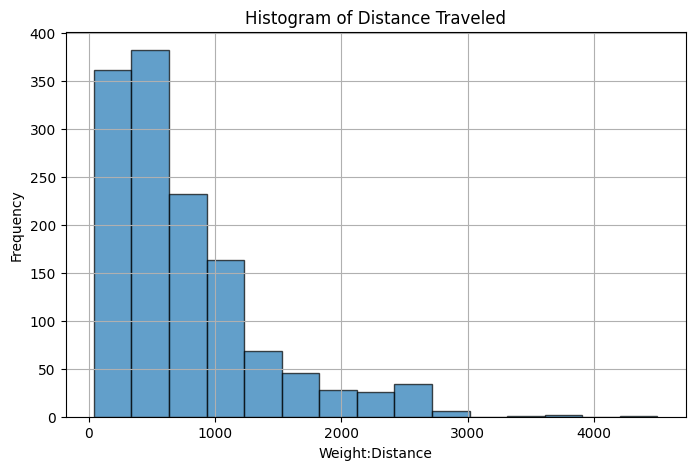

In [ ]:


#Extract the connected subgraph
weights = [d['weight'] for u, v, d in g.edges(data=True)]

# Create a Pandas Series for easy visualization
weight_series = pd.Series(weights)

# Plot histogram
plt.figure(figsize=(8, 5))
weight_series.hist(bins=15, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel("Weight:Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Distance Traveled")

# Show the histogram
plt.show()

In [ ]:
#Create Function to Trim Edges 
def trim_edges(g, weight):
    """
    Remove edges with weight ≤ threshold and return a new graph.
    """
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata["weight"] > weight:
            g2.add_edge(f, to, **edata)  # Preserve edge attributes
    return g2

In [ ]:

# Create the bipartite weighted projected graph for destination cities 
citynet = bi.weighted_projected_graph(g, destcities, ratio=False)

# Get connected components and extract the first component (assuming the graph is connected)
components = list(nx.connected_components(citynet))
citynet = citynet.subgraph(components[0]).copy()

edges_data = list(citynet.edges(data=True))
edges_data[:10]

[(30397, 33792, {'weight': 3}),
 (30397, 30721, {'weight': 10}),
 (30397, 35841, {'weight': 1}),
 (30397, 34819, {'weight': 8}),
 (30397, 33795, {'weight': 3}),
 (30397, 30728, {'weight': 2}),
 (30397, 30731, {'weight': 2}),
 (30397, 30732, {'weight': 4}),
 (30397, 34828, {'weight': 3}),
 (30397, 30739, {'weight': 2})]

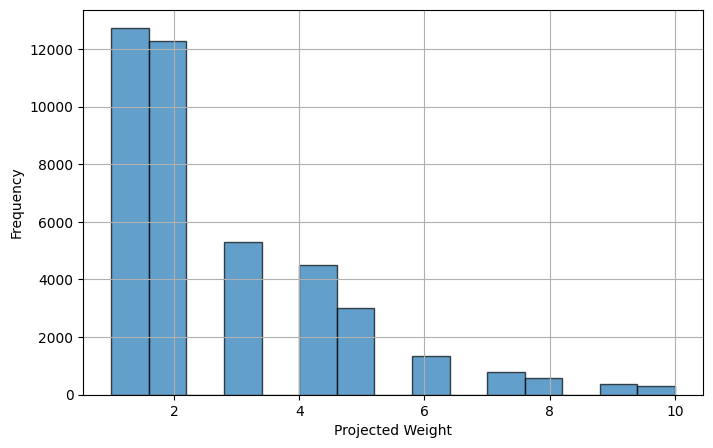

In [ ]:
#Extract the connected subgraph
weights = [d['weight'] for u, v, d in citynet.edges(data=True)]

# Create a Pandas Series for easy visualization
weight_series = pd.Series(weights)

# Plot histogram
plt.figure(figsize=(8, 5))
weight_series.hist(bins=15, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel("Projected Weight")
plt.ylabel("Frequency")
#plt.title("Histogram of DisTraveledtance ")

# Show the histogram
plt.show()

In [ ]:
citynet_trim = trim_edges(citynet, weight=7)

Text(0.5, 1.0, 'Projected Network Graph for Desitination Cities, Edges trimmed to min 7')

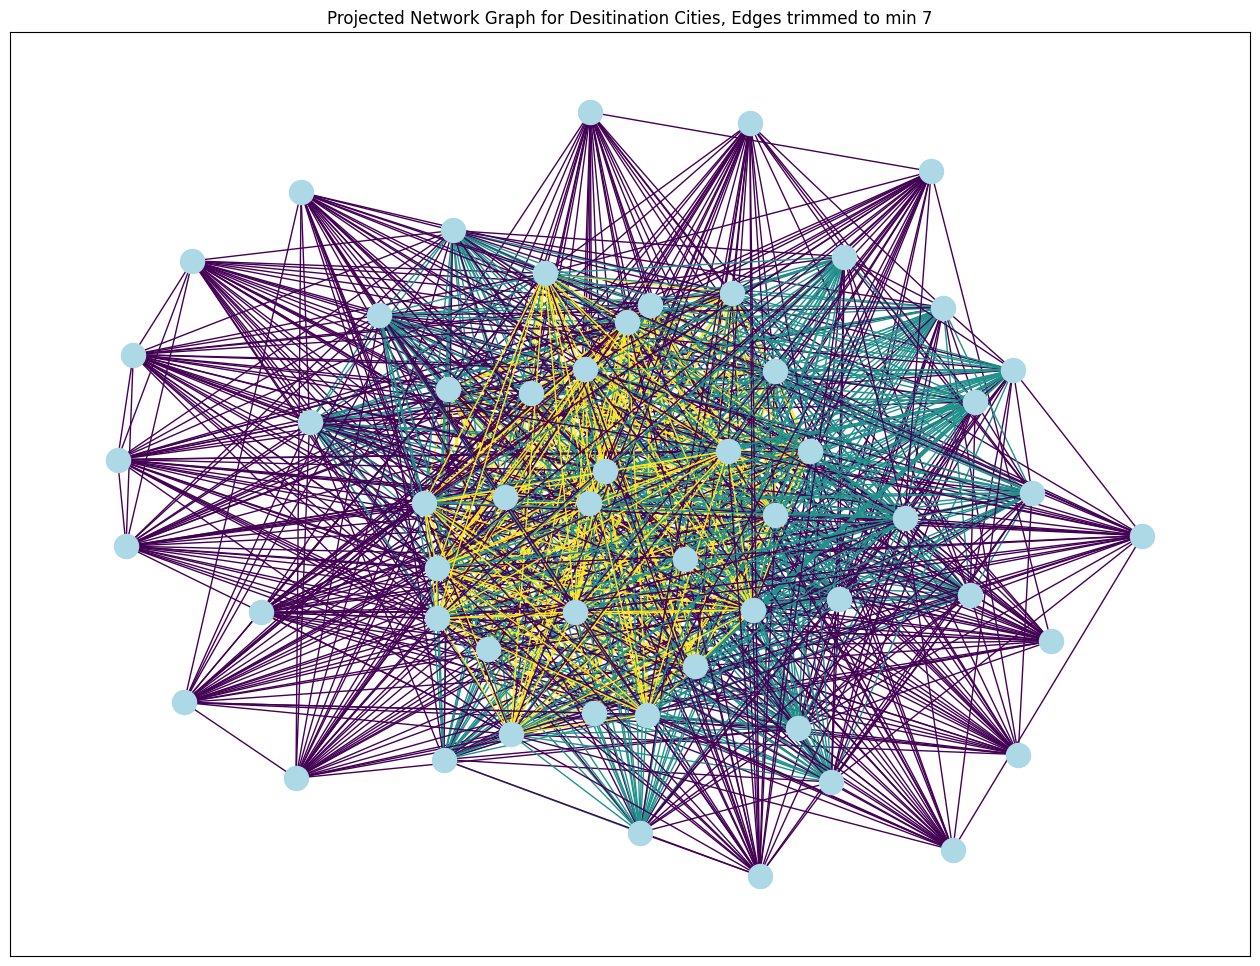

In [ ]:
weights = [edata['weight'] for _, _, edata in citynet_trim.edges(data=True)]


# Visualize the graph with edge width and color based on weights
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(citynet_trim)  # Positioning layout

# Draw the network with width and color based on the weights
nx.draw_networkx(
    citynet_trim, pos, 
    with_labels=False, 
    node_color='lightblue', 
    edge_color=weights,   # Edge color based on weight
    #width=weights,        # Edge width based on weight
    #edge_cmap=plt.cm.Blues  # Color map for edges
)

# Show the plot
plt.title("Projected Network Graph for Desitination Cities, Edges trimmed to min 7")

In [ ]:
# Create the bipartite weighted projected graph for carriers 
carriernet = bi.weighted_projected_graph(g, carriers, ratio=False)

# Get connected components and extract the first component (assuming the graph is connected)
components = list(nx.connected_components(carriernet))
carriernetnet = carriernet.subgraph(components[0]).copy()

edges_data = list(carriernet.edges(data=True))
edges_data[:10]

[('DL', 'AA', {'weight': 145}),
 ('DL', 'UA', {'weight': 141}),
 ('DL', 'B6', {'weight': 55}),
 ('DL', 'NK', {'weight': 53}),
 ('DL', 'AS', {'weight': 73}),
 ('DL', 'MQ', {'weight': 114}),
 ('DL', 'WN', {'weight': 84}),
 ('DL', 'F9', {'weight': 68}),
 ('DL', 'OO', {'weight': 160}),
 ('F9', 'UA', {'weight': 68})]

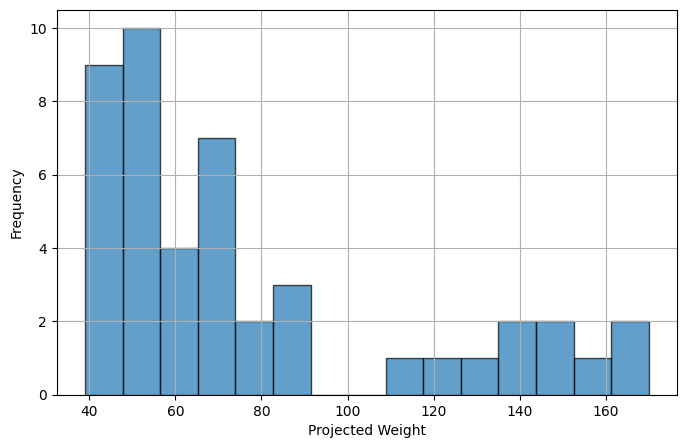

In [144]:
#Extract the connected subgraph
weights = [d['weight'] for u, v, d in carriernet.edges(data=True)]

# Create a Pandas Series for easy visualization
weight_series = pd.Series(weights)

# Plot histogram
plt.figure(figsize=(8, 5))
weight_series.hist(bins=15, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel("Projected Weight")
plt.ylabel("Frequency")
#plt.title("Histogram of DisTraveledtance ")

# Show the histogram
plt.show()

In [150]:
carriernet_trim = trim_edges(carriernet, weight=30)

Text(0.5, 1.0, 'Projected Network Graph for Carriers, Edges trimmed to min 30')

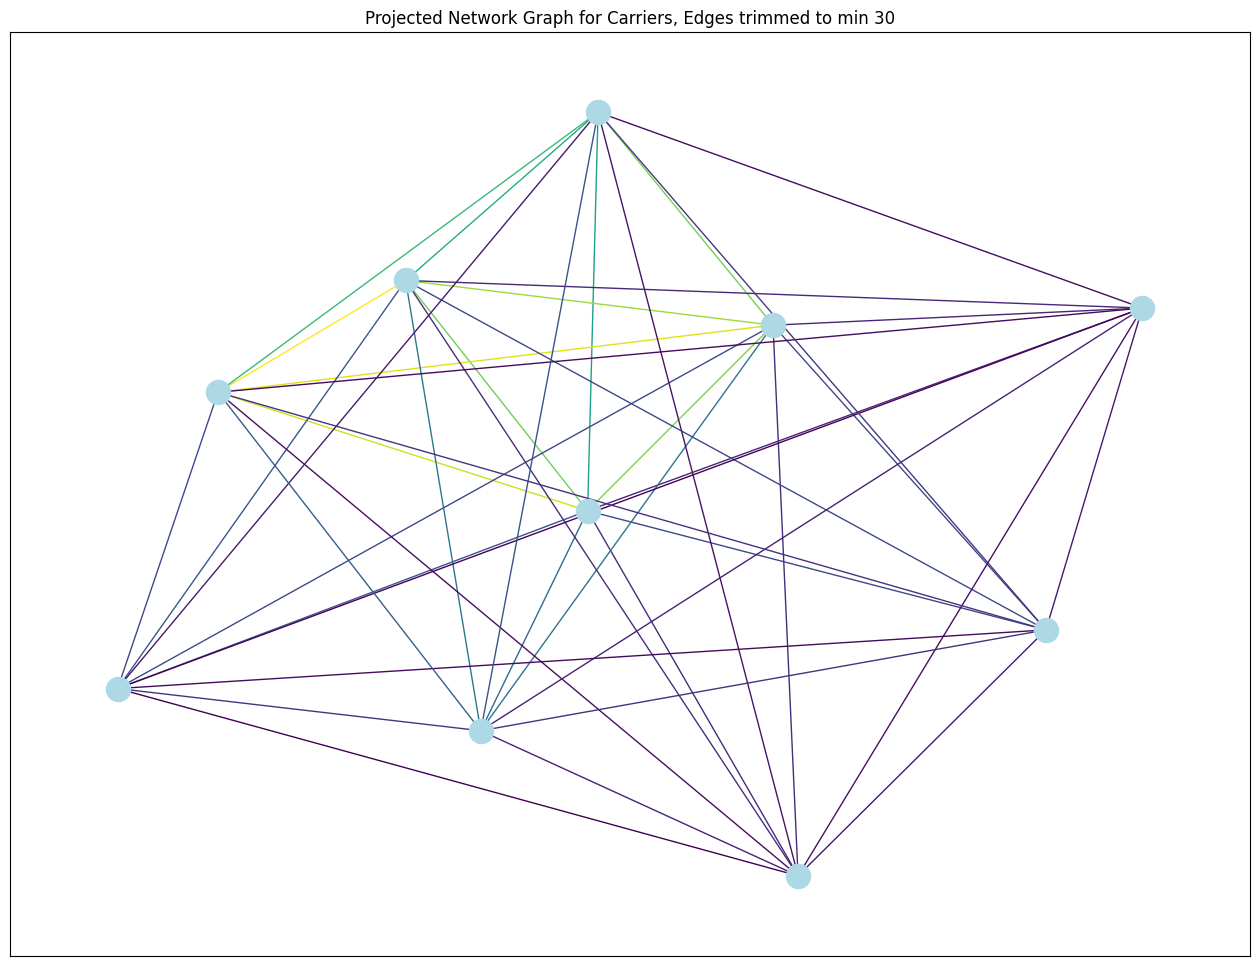

In [152]:
weights = [edata['weight'] for _, _, edata in carriernet_trim.edges(data=True)]


# Visualize the graph with edge width and color based on weights
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(carriernet_trim)  # Positioning layout

# Draw the network with width and color based on the weights
nx.draw_networkx(
    carriernet_trim, pos, 
    with_labels=False, 
    node_color='lightblue', 
    edge_color=weights,   # Edge color based on weight
    #width=weights,        # Edge width based on weight
    #edge_cmap=plt.cm.Blues  # Color map for edges
)

# Show the plot
plt.title("Projected Network Graph for Carriers, Edges trimmed to min 30")

## **Conclusion**
Both the destination city and carrier affiliation network do not indicate any clear cohesive clusters.  